### Drive mount and package import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
import os
import time
import random

import numpy as np
from PIL import Image, ImageStat
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models




In [3]:
# data 경로 설정 
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "data")

### MyLOSS

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torchvision.models.vgg import vgg16
import numpy as np


class L_color(nn.Module):

    def __init__(self):
        super(L_color, self).__init__()

    def forward(self, x ):

        b,c,h,w = x.shape

        mean_rgb = torch.mean(x,[2,3],keepdim=True)
        mr,mg, mb = torch.split(mean_rgb, 1, dim=1)
        Drg = torch.pow(mr-mg,2)
        Drb = torch.pow(mr-mb,2)
        Dgb = torch.pow(mb-mg,2)
        k = torch.pow(torch.pow(Drg,2) + torch.pow(Drb,2) + torch.pow(Dgb,2),0.5)


        return k

			
class L_spa(nn.Module):

    def __init__(self):
        super(L_spa, self).__init__()
        # print(1)kernel = torch.FloatTensor(kernel).unsqueeze(0).unsqueeze(0)
        kernel_left = torch.FloatTensor( [[0,0,0],[-1,1,0],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_right = torch.FloatTensor( [[0,0,0],[0,1,-1],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_up = torch.FloatTensor( [[0,-1,0],[0,1, 0 ],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_down = torch.FloatTensor( [[0,0,0],[0,1, 0],[0,-1,0]]).cuda().unsqueeze(0).unsqueeze(0)
        self.weight_left = nn.Parameter(data=kernel_left, requires_grad=False)
        self.weight_right = nn.Parameter(data=kernel_right, requires_grad=False)
        self.weight_up = nn.Parameter(data=kernel_up, requires_grad=False)
        self.weight_down = nn.Parameter(data=kernel_down, requires_grad=False)
        self.pool = nn.AvgPool2d(4)
    def forward(self, org , enhance ):
        b,c,h,w = org.shape

        org_mean = torch.mean(org,1,keepdim=True)
        enhance_mean = torch.mean(enhance,1,keepdim=True)

        org_pool =  self.pool(org_mean)			
        enhance_pool = self.pool(enhance_mean)	

        weight_diff =torch.max(torch.FloatTensor([1]).cuda() + 10000*torch.min(org_pool - torch.FloatTensor([0.3]).cuda(),torch.FloatTensor([0]).cuda()),torch.FloatTensor([0.5]).cuda())
        E_1 = torch.mul(torch.sign(enhance_pool - torch.FloatTensor([0.5]).cuda()) ,enhance_pool-org_pool)


        D_org_letf = F.conv2d(org_pool , self.weight_left, padding=1)
        D_org_right = F.conv2d(org_pool , self.weight_right, padding=1)
        D_org_up = F.conv2d(org_pool , self.weight_up, padding=1)
        D_org_down = F.conv2d(org_pool , self.weight_down, padding=1)

        D_enhance_letf = F.conv2d(enhance_pool , self.weight_left, padding=1)
        D_enhance_right = F.conv2d(enhance_pool , self.weight_right, padding=1)
        D_enhance_up = F.conv2d(enhance_pool , self.weight_up, padding=1)
        D_enhance_down = F.conv2d(enhance_pool , self.weight_down, padding=1)

        D_left = torch.pow(D_org_letf - D_enhance_letf,2)
        D_right = torch.pow(D_org_right - D_enhance_right,2)
        D_up = torch.pow(D_org_up - D_enhance_up,2)
        D_down = torch.pow(D_org_down - D_enhance_down,2)
        E = (D_left + D_right + D_up +D_down)
        # E = 25*(D_left + D_right + D_up +D_down)

        return E
class L_exp(nn.Module):

    def __init__(self,patch_size,mean_val):
        super(L_exp, self).__init__()
        # print(1)
        patch_size = 16
        mean_val = 0.6
        self.pool = nn.AvgPool2d(patch_size)
        self.mean_val = mean_val
    def forward(self, x ):

        b,c,h,w = x.shape
        x = torch.mean(x,1,keepdim=True)
        mean = self.pool(x)

        d = torch.mean(torch.pow(mean- torch.FloatTensor([self.mean_val] ).cuda(),2))
        return d
        
class L_TV(nn.Module):
    def __init__(self,TVLoss_weight=1):
        super(L_TV,self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self,x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h =  (x.size()[2]-1) * x.size()[3]
        count_w = x.size()[2] * (x.size()[3] - 1)
        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size
class Sa_Loss(nn.Module):
    def __init__(self):
        super(Sa_Loss, self).__init__()
        # print(1)
    def forward(self, x ):
        # self.grad = np.ones(x.shape,dtype=np.float32)
        b,c,h,w = x.shape
        # x_de = x.cpu().detach().numpy()
        r,g,b = torch.split(x , 1, dim=1)
        mean_rgb = torch.mean(x,[2,3],keepdim=True)
        mr,mg, mb = torch.split(mean_rgb, 1, dim=1)
        Dr = r-mr
        Dg = g-mg
        Db = b-mb
        k =torch.pow( torch.pow(Dr,2) + torch.pow(Db,2) + torch.pow(Dg,2),0.5)
        # print(k)
        

        k = torch.mean(k)
        return k

class perception_loss(nn.Module):
    def __init__(self):
        super(perception_loss, self).__init__()
        features = vgg16(pretrained=True).features
        self.to_relu_1_2 = nn.Sequential() 
        self.to_relu_2_2 = nn.Sequential() 
        self.to_relu_3_3 = nn.Sequential()
        self.to_relu_4_3 = nn.Sequential()

        for x in range(4):
            self.to_relu_1_2.add_module(str(x), features[x])
        for x in range(4, 9):
            self.to_relu_2_2.add_module(str(x), features[x])
        for x in range(9, 16):
            self.to_relu_3_3.add_module(str(x), features[x])
        for x in range(16, 23):
            self.to_relu_4_3.add_module(str(x), features[x])
        
        # don't need the gradients, just want the features
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.to_relu_1_2(x)
        h_relu_1_2 = h
        h = self.to_relu_2_2(h)
        h_relu_2_2 = h
        h = self.to_relu_3_3(h)
        h_relu_3_3 = h
        h = self.to_relu_4_3(h)
        h_relu_4_3 = h
        # out = (h_relu_1_2, h_relu_2_2, h_relu_3_3, h_relu_4_3)
        return h_relu_4_3


### MODEL

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
#import pytorch_colors as colors
import numpy as np

class enhance_net_nopool(nn.Module):

	def __init__(self):
		super(enhance_net_nopool, self).__init__()

		self.relu = nn.ReLU(inplace=True)

		number_f = 32
		self.e_conv1 = nn.Conv2d(3,number_f,3,1,1,bias=True) 
		self.e_conv2 = nn.Conv2d(number_f,number_f,3,1,1,bias=True) 
		self.e_conv3 = nn.Conv2d(number_f,number_f,3,1,1,bias=True) 
		self.e_conv4 = nn.Conv2d(number_f,number_f,3,1,1,bias=True) 
		self.e_conv5 = nn.Conv2d(number_f*2,number_f,3,1,1,bias=True) 
		self.e_conv6 = nn.Conv2d(number_f*2,number_f,3,1,1,bias=True) 
		self.e_conv7 = nn.Conv2d(number_f*2,24,3,1,1,bias=True) 

		self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
		self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)


		
	def forward(self, x):

		x1 = self.relu(self.e_conv1(x))
		# p1 = self.maxpool(x1)
		x2 = self.relu(self.e_conv2(x1))
		# p2 = self.maxpool(x2)
		x3 = self.relu(self.e_conv3(x2))
		# p3 = self.maxpool(x3)
		x4 = self.relu(self.e_conv4(x3))

		x5 = self.relu(self.e_conv5(torch.cat([x3,x4],1)))
		# x5 = self.upsample(x5)
		x6 = self.relu(self.e_conv6(torch.cat([x2,x5],1)))

		x_r = F.tanh(self.e_conv7(torch.cat([x1,x6],1)))
		r1,r2,r3,r4,r5,r6,r7,r8 = torch.split(x_r, 3, dim=1)


		x = x + r1*(torch.pow(x,2)-x)
		x = x + r2*(torch.pow(x,2)-x)
		x = x + r3*(torch.pow(x,2)-x)
		enhance_image_1 = x + r4*(torch.pow(x,2)-x)		
		x = enhance_image_1 + r5*(torch.pow(enhance_image_1,2)-enhance_image_1)		
		x = x + r6*(torch.pow(x,2)-x)	
		x = x + r7*(torch.pow(x,2)-x)
		enhance_image = x + r8*(torch.pow(x,2)-x)
		r = torch.cat([r1,r2,r3,r4,r5,r6,r7,r8],1)
		return enhance_image_1,enhance_image,r

### Dataset Split, DataLoader

In [20]:
# ColabNotebook/data/zero-dice/train_data 경로를 만드시고
# train_data에 zero-dice model 다운 받았을때 있는 train_data를 넣으시면 됩니다.
lowlight_images_path = os.path.join(root,'zero-dice/train_data')

In [6]:
import os
import sys

import torch
import torch.utils.data as data

import numpy as np
from PIL import Image
import glob
import random
import cv2

random.seed(1143)


def populate_train_list(lowlight_images_path):




	image_list_lowlight = glob.glob(lowlight_images_path + "*.jpg")

	train_list = image_list_lowlight

	random.shuffle(train_list)

	return train_list

	

class lowlight_loader(data.Dataset):

	def __init__(self, lowlight_images_path):

		self.train_list = populate_train_list(lowlight_images_path) 
		self.size = 256

		self.data_list = self.train_list
		print("Total training examples:", len(self.train_list))


		

	def __getitem__(self, index):

		data_lowlight_path = self.data_list[index]
		
		data_lowlight = Image.open(data_lowlight_path)
		
		data_lowlight = data_lowlight.resize((self.size,self.size), Image.ANTIALIAS)

		data_lowlight = (np.asarray(data_lowlight)/255.0) 
		data_lowlight = torch.from_numpy(data_lowlight).float()

		return data_lowlight.permute(2,0,1)

	def __len__(self):
		return len(self.data_list)



### Train

In [8]:
from numpy.testing._private.utils import assert_no_gc_cycles
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim
import os
import sys
import argparse
import time
# import dataloader
# import model
# import Myloss
import numpy as np
from torchvision import transforms
import easydict

device = "cuda"

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


def train(config):

	os.environ['CUDA_VISIBLE_DEVICES']='0'

	DCE_net = enhance_net_nopool().cuda()

	DCE_net.apply(weights_init)
	if config.load_pretrain == True:
	    DCE_net.load_state_dict(torch.load(config.pretrain_dir))
	train_dataset = lowlight_loader(config.lowlight_images_path)		
	
	train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True, num_workers=config.num_workers, pin_memory=True)


	# L_color = L_color()
	# L_spa = L_spa()

	# L_exp = L_exp(16,0.6)
	# L_TV = L_TV()

	optimizer = torch.optim.Adam(DCE_net.parameters(), lr=config.lr, weight_decay=config.weight_decay)
	
	DCE_net.train()

	for epoch in range(config.num_epochs):
		for iteration, img_lowlight in enumerate(train_loader):

			img_lowlight = img_lowlight.cuda()

			enhanced_image_1,enhanced_image,A  = DCE_net(img_lowlight)

			Loss_TV = 200*L_TV(A)
			
			loss_spa = torch.mean(L_spa(enhanced_image, img_lowlight))

			loss_col = 5*torch.mean(L_color(enhanced_image))

			loss_exp = 10*torch.mean(L_exp(enhanced_image))
			
			
			# best_loss
			loss =  Loss_TV + loss_spa + loss_col + loss_exp
			#

			
			optimizer.zero_grad()
			loss.backward()
			torch.nn.utils.clip_grad_norm(DCE_net.parameters(),config.grad_clip_norm)
			optimizer.step()

			if ((iteration+1) % config.display_iter) == 0:
				print("Loss at iteration", iteration+1, ":", loss.item())
			if ((iteration+1) % config.snapshot_iter) == 0:
				
				torch.save(DCE_net.state_dict(), config.snapshots_folder + "Epoch" + str(epoch) + '.pth') 		




if __name__ == "__main__":

	# parser = argparse.ArgumentParser()

	# # Input Parameters
	# parser.add_argument('--lowlight_images_path', type=str, default=os.path.join(root,'zero-dice/train_data'))
	# parser.add_argument('--lr', type=float, default=0.0001)
	# parser.add_argument('--weight_decay', type=float, default=0.0001)
	# parser.add_argument('--grad_clip_norm', type=float, default=0.1)
	# parser.add_argument('--num_epochs', type=int, default=200)
	# parser.add_argument('--train_batch_size', type=int, default=8)
	# parser.add_argument('--val_batch_size', type=int, default=4)
	# parser.add_argument('--num_workers', type=int, default=4)
	# parser.add_argument('--display_iter', type=int, default=10)
	# parser.add_argument('--snapshot_iter', type=int, default=10)
	# parser.add_argument('--snapshots_folder', type=str, default=os.path.join(root,'zero-dice/snapshots'))
	# parser.add_argument('--load_pretrain', type=bool, default= False)
	# parser.add_argument('--pretrain_dir', type=str, default= os.path.join(root,'zero-dice/snapshots/Epoch99.pth'))

	# config = parser.parse_args()

	# if not os.path.exists(config.snapshots_folder):
	# 	os.mkdir(config.snapshots_folder)
  
	# config = args로 학습시 필요한 하이퍼파라미터입니다.
	# colab 환경에서 위의 parser 코드가 실행되지 않아 easydict형태를 사용했습니다.
  args = easydict.EasyDict({
      "lowlight_images_path" : os.path.join(root,'zero-dice/train_data'),

      "lr" : 0.0001,

      "weight_decay" : 0.0001,

      "grad_clip_norm" : 0.1,

      "num_epochs" : 10,

      "train_batch_size" : 8,

      "val_batch_size" : 4,

      "num_workers" : 4,

      "display_iter" : 10,

      "snapshot_iter" : 10,

      "snapshots_folder" : os.path.join(root,'zero-dice/snapshots'),

      "load_pretrain" : False,

      "pretrain_dir" : os.path.join(root,'zero-dice/snapshots/Epoch99.pth')
  })

  config = args
  
  if not os.path.exists(config.snapshots_folder):
	    os.mkdir(config.snapshots_folder)

### Test

In [9]:
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim
import os
import sys
import argparse
import time
# import dataloader
# import model
import numpy as np
from torchvision import transforms
from PIL import Image
import glob
import time


 
def lowlight(image_path):
	# os.environ['CUDA_VISIBLE_DEVICES']='0'
	device = "cuda"
	data_lowlight = Image.open(image_path)

 

	data_lowlight = (np.asarray(data_lowlight)/255.0)


	data_lowlight = torch.from_numpy(data_lowlight).float()
	data_lowlight = data_lowlight.permute(2,0,1)
	data_lowlight = data_lowlight.cuda().unsqueeze(0)

	DCE_net = enhance_net_nopool().cuda()
	DCE_net.load_state_dict(torch.load(os.path.join(root,'zero-dice/snapshots/Epoch99.pth')))
	start = time.time()
	_,enhanced_image,_ = DCE_net(data_lowlight)

	end_time = (time.time() - start)
	print(end_time)
	image_path = image_path.replace('test_data','result')
	result_path = image_path
	if not os.path.exists(image_path.replace('/'+image_path.split("/")[-1],'')):
		os.makedirs(image_path.replace('/'+image_path.split("/")[-1],''))

	torchvision.utils.save_image(enhanced_image, result_path)

if __name__ == '__main__':
# test_images
	with torch.no_grad():
		filePath = os.path.join(root, 'zero-dice/test_data')
	
		file_list = os.listdir(filePath)

		for file_name in file_list:
			test_list = glob.glob(filePath+file_name+"/*") 
			for image in test_list:
				# image = image
				print(image)
				lowlight(image)

		



#### TEST_folder의 이미지 테스트


In [10]:
# ColabNotebook/data/zero-dice/test_data/SOCAR 경로를 만드시고
# 해당 경로에 test해볼 SOCAR이미지를 넣으시면 됩니다.
with torch.no_grad():
  filePath = os.path.join(root, 'zero-dice/test_data')

  file_name = 'SOCAR'

  test_list = glob.glob(filePath + "/" + file_name + "/*")
  for image in test_list:
    print(image)
    lowlight(image)

/content/drive/MyDrive/Colab Notebooks/data/zero-dice/test_data/SOCAR/20190412_9286_21811842_e7f95f9347d3762d6bb7c638214c0a15.jpg


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0.14415884017944336
/content/drive/MyDrive/Colab Notebooks/data/zero-dice/test_data/SOCAR/20190513_4518_23258118_8b2b9edc7124a49ed955d940a6fbbbb5.jpg
0.002745389938354492
/content/drive/MyDrive/Colab Notebooks/data/zero-dice/test_data/SOCAR/20190502_6622_22639119_e6ef8aa3c4e27617e1eeaca0ffb850e1.jpg
0.002951383590698242


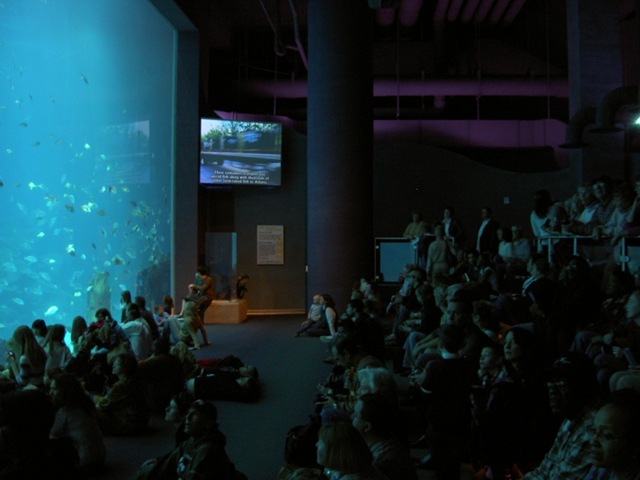

In [11]:
# 변환 전후 이미지 출력하기
import matplotlib.pyplot as plt

origin_image = os.path.join(root, 'zero-dice/test_data/DICM/17.jpg')
result_image = os.path.join(root, 'zero-dice/result/DICM/17.jpg')

Image.open(origin_image)


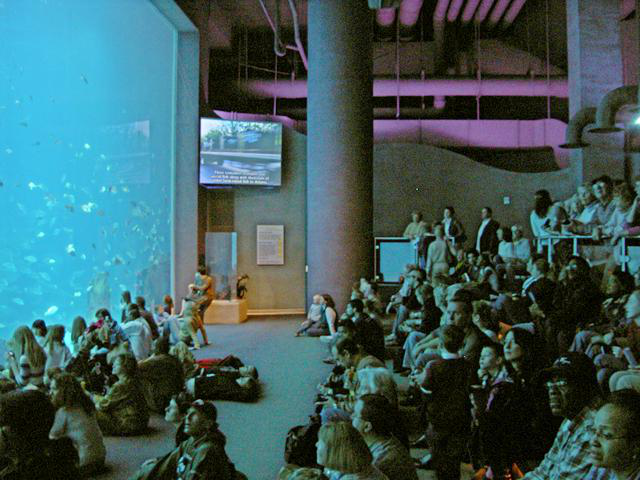

In [12]:
Image.open(result_image)

#### SOCAR 이미지 테스트
- 나란히 확인하기 위해서 아래와 같은 변환을 거쳤습니다.

In [13]:
image1 = os.path.join(root, 'zero-dice/test_data/SOCAR/20190502_6622_22639119_e6ef8aa3c4e27617e1eeaca0ffb850e1.jpg') #SOCAR TEST
image2 = os.path.join(root, 'zero-dice/result/SOCAR/20190502_6622_22639119_e6ef8aa3c4e27617e1eeaca0ffb850e1.jpg') #SOCAR RESULT
image1 = Image.open(image1)
image2 = Image.open(image2)

In [14]:
image1 = image1.resize((int(image1.size[0]*0.5), int(image1.size[1]*0.5)), Image.ANTIALIAS)
image2 = image2.resize((int(image2.size[0]*0.5), int(image2.size[1]*0.5)), Image.ANTIALIAS)

In [15]:
image1_size = image1.size
image2_size = image2.size
new_image = Image.new('RGB',(2*image1_size[0], image1_size[1]), (250,250,250))

In [16]:
new_image.paste(image1,(0,0))
new_image.paste(image2,(image1_size[0],0))

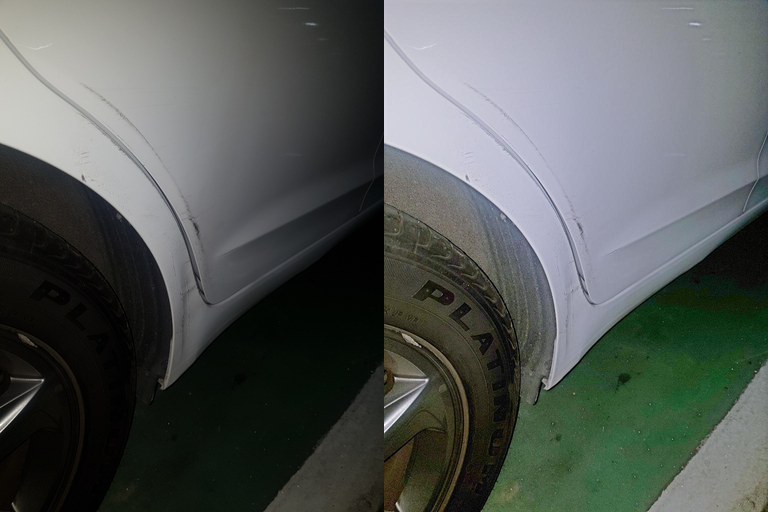

In [17]:
new_image

### perceived brightness 파악

In [26]:
# 위의 좌측 이미지 경로
image1 = os.path.join(root, 'zero-dice/test_data/SOCAR/20190502_6622_22639119_e6ef8aa3c4e27617e1eeaca0ffb850e1.jpg')

In [27]:
def brightness( im_file ):
   im = Image.open(im_file)
   stat = ImageStat.Stat(im)
   r,g,b = stat.mean
   return math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2))

In [28]:
brightness(image1)

62.451558259820025